In [2]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\behdad\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [4]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [5]:
my_df.target.value_counts()

0    798197
1    797844
Name: target, dtype: int64

## Train / Dev / Test Split

Before we can train any model, we first consider how to split the data. Here I chose to split the data into three chunks: train, development, test. I referenced Andrew Ng's "deeplearning.ai" course on how to split the data.

- Train set: The sample of data used for learning
- Development set (Hold-out cross-validation set): The sample of data used to tune the parameters of a classifier, and provide an unbiased evaluation of a model.
- Test set: The sample of data used only to assess the performance of a final model.

The ratio I decided to split my data is 98/1/1, 98% of data as the training set, and 1% for the dev set, and the final 1% for the test set. The rationale behind this ratio comes from the size of my whole data set. The dataset has more than 1.5 million entries. In this case, only 1% of the whole data gives me more than 15,000 entries. This is more than enough to evaluate the model and refine the parameters.

Another approach is splitting the data into only train and test set, and run k-fold cross-validation on the training set, so that you can have an unbiased evaluation of a model. But considering the size of the data, I have decided to use the train set only to train a model, and evaluate on the dev set, so that I can quickly test different algorithms and run this process iteratively.

In [4]:
x = my_df.text
y = my_df.target

In [5]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [6]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has total 15960 entries with 49.45% negative, 50.55% positive
Test set has total 15961 entries with 49.68% negative, 50.32% positive


## Baseline

When comparing various machine learning algorithms, baseline provides a point of reference to compare.
The most popular baseline is the Zero Rule (ZeroR). ZeroR classifier simply predicts the majority category (class). Although there is no predictability power in ZeroR, it is useful for determining a baseline performance as a benchmark for other classification methods. As you can see from the above validation set class division, the majority class is negative with 50.40%, which means if a classifier predicts negative for every validation data, it will get 50.40% accuracy.

Another baseline I wanted to compare the validation results with is TextBlob. Textblob is a python library for processing textual data. Apart from other useful tools such as POS tagging, n-gram, The package has built-in sentiment classification. This is a so-called out-of-the-box sentiment analysis tool, and in addition to the null accuracy, I will also keep in mind of the accuracy I get from TextBlob sentiment analysis to see how my model is performing.

In [7]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

Wall time: 4.34 s


In [9]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 61.84%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7282                 785
negative                5306                2587
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      7893
           1       0.58      0.90      0.71      8067

    accuracy                           0.62     15960
   macro avg       0.67      0.62      0.58     15960
weighted avg       0.67      0.62      0.58     15960



TextBlob sentiment analysis yielded 60.65% accuracy on the validation set, which is 10.25% more accurate than null accuracy (50.40%).

## Feature Extraction

If we want to use text in machine learning algorithms, we’ll have to convert them to a numerical representation.
One of the methods is called bag-of-words approach. The bag of words model ignores grammar and order of words.
Once we have a corpus (text data) then first, a list of vocabulary is created based on the entire corpus.
Then each document or data entry is represented as numerical vectors based on the vocabulary built from the corpus.

### Count Vectorizer

With count vectorizer, we merely count the appearance of the words in each text. For example, let's say we have 3 documents in a corpus: "I love dogs", "I hate dogs and knitting", "Knitting is my hobby and my passion".
If we build vocabulary from these three sentences and represent each document as count vectors, it will look like below pictures.

![title](img/cvec.jpeg)


But if the size of the corpus gets big, the number of vocabulary gets too big to process. With my 1.5 million tweets, if I build vocabulary without limiting the number of vocabulary, I will have more than 260,000 vocabularies. This means that the shape of training data will be around 1,500,000 x 260,000, this sounds too big to train various different models with. So I decided to limit the number of vocabularies, but I also wanted to see how the performance varies depending on the number of vocabularies.

Another thing I wanted to explore is stopwords. Stop Words are words which do not contain important significance, such as "the", "of", etc. It is often assumed that removing stopwords is a necessary step, and will improve the model performance. But I wanted to see for myself if this is really the case. So I ran the same test with and without stop words and compared the result. In addition, I also defined my custom stopwords list, which contains top 10 most frequent words in the corpus: "to", "the", "my", "it", "and", "you", "not", "is", "in", "for".

A model I chose to evaluate different count vectors is the logistic regression. It is one of the linear models, so computationally scalable to big data, compared to models like KNN or random forest. And once I have the optimal number of features and make a decision on whether to remove stop words or not, then I will try different models with the chosen number of vocabularies' count vectors.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

Below I define two functions to iteratively train on a different number of features, then check the accuracy of logistic regression on the validation set.

In [12]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [13]:
cvec = CountVectorizer()
lr = LogisticRegression(solver='liblinear')
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print( (classifier))
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print( "Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

#### Unigram

In [14]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.34%
model is 26.80% more accurate than null accuracy
train and test time: 91.98s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.66%
model is 27.11% more accurate than null accuracy
train and test time: 109.34s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.78%
model is 27.24% more accurate than null accuracy
train and test time: 131.48s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.72%
model is 27.17% more accurate than null accuracy
train and test time: 151.98s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.74%
model is 27.19% more accurate than null accuracy
train and test time: 156.47s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.86%
model is 27.32% more accurate than null accuracy
train and test time: 150.28s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.86%
model is 27.31% more accurate than null accuracy
train and test time: 169.87s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.78%
model is 27.24% more accurate than null accuracy
train and test time: 169.06s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.79%
model is 27.25% more accurate than null accuracy
train and test time: 163.50s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.77%
model is 27.22% more accurate than null accuracy
train and test time: 169.04s
--------------------------------------------------------------------------------
Wall time: 24min 23s


In [15]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.66%
model is 29.11% more accurate than null accuracy
train and test time: 185.48s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.82%
model is 29.27% more accurate than null accuracy
train and test time: 242.78s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.76%
model is 29.22% more accurate than null accuracy
train and test time: 271.68s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.77%
model is 29.22% more accurate than null accuracy
train and test time: 307.05s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.83%
model is 29.29% more accurate than null accuracy
train and test time: 269.72s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.86%
model is 29.32% more accurate than null accuracy
train and test time: 318.67s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.94%
model is 29.39% more accurate than null accuracy
train and test time: 303.76s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.96%
model is 29.41% more accurate than null accuracy
train and test time: 273.88s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 80.01%
model is 29.47% more accurate than null accuracy
train and test time: 348.03s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 80.01%
model is 29.47% more accurate than null accuracy
train and test time: 343.60s
--------------------------------------------------------------------------------
Wall time: 47min 44s


In [16]:
csv = 'term_freq_df.csv'
term_freq_df = pd.read_csv(csv,index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


In [17]:
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [18]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [19]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 78.84%
model is 28.30% more accurate than null accuracy
train and test time: 128.72s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.00%
model is 28.45% more accurate than null accuracy
train and test time: 156.38s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.04%
model is 28.50% more accurate than null accuracy
train and test time: 176.46s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.05%
model is 28.51% more accurate than null accuracy
train and test time: 204.63s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.04%
model is 28.49% more accurate than null accuracy
train and test time: 233.80s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.10%
model is 28.56% more accurate than null accuracy
train and test time: 237.95s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.11%
model is 28.57% more accurate than null accuracy
train and test time: 214.53s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.10%
model is 28.55% more accurate than null accuracy
train and test time: 296.69s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.05%
model is 28.50% more accurate than null accuracy
train and test time: 272.84s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.04%
model is 28.49% more accurate than null accuracy
train and test time: 278.58s
--------------------------------------------------------------------------------
Wall time: 36min 40s


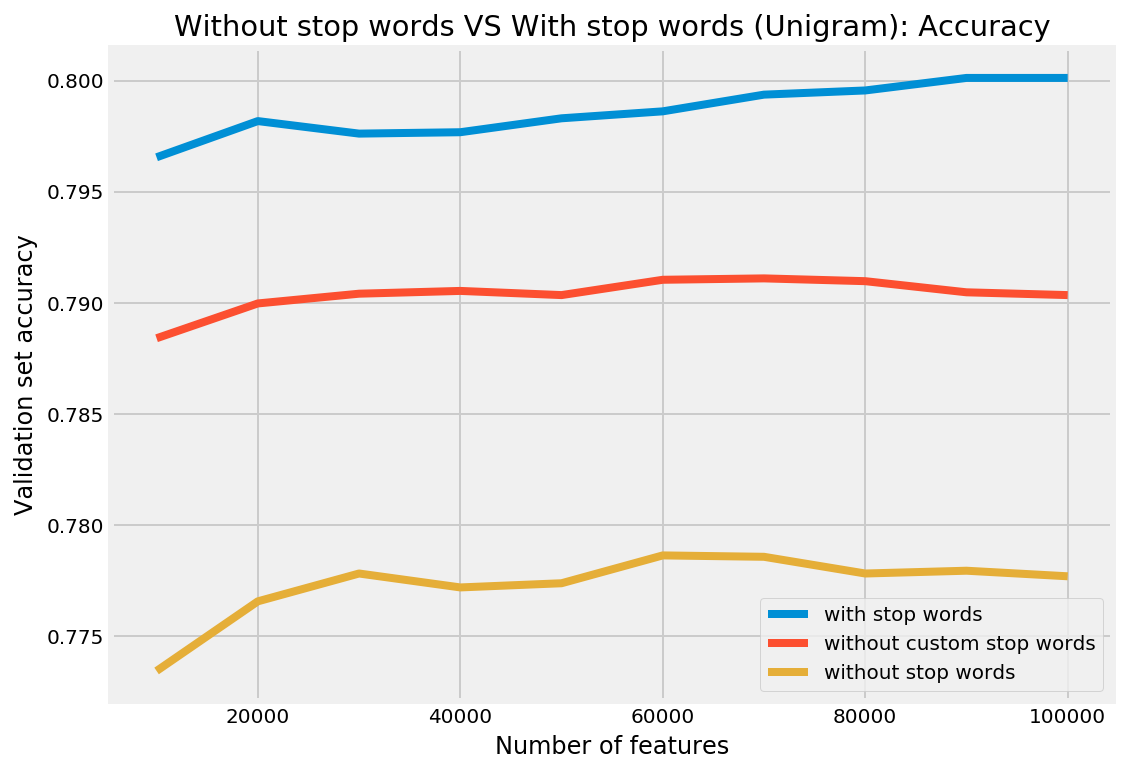

In [20]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

By looking at the evaluation result, removing stop words did not improve the model performance, but keeping the stop words yielded better performance. I wouldn't say that removing stopwords are not helping the model performance every time, but as empirical findings, in this particular setting, keeping the stop words improve the model performance.

#### Bigram

According to Wikipedia, "n-gram is a contiguous sequence of n items from a given sequence of text or speech". In other words, n-grams are simply all combinations of adjacent words or letters of length n that you can find in your source text. Below picture represents well how n-grams are constructed out of source text.

![title](img/bigram.png)

In this project, I will extend the bag-of-words to trigrams, and see if it affects the performance.

In [21]:
%%time
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 80.58%
model is 30.04% more accurate than null accuracy
train and test time: 299.77s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.39%
model is 30.85% more accurate than null accuracy
train and test time: 333.08s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.80%
model is 31.25% more accurate than null accuracy
train and test time: 307.57s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.91%
model is 31.37% more accurate than null accuracy
train and test time: 377.99s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.94%
model is 31.40% more accurate than null accuracy
train and test time: 524.99s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.99%
model is 31.45% more accurate than null accuracy
train and test time: 555.77s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.22%
model is 31.68% more accurate than null accuracy
train and test time: 564.93s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.05%
model is 31.50% more accurate than null accuracy
train and test time: 494.81s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.14%
model is 31.60% more accurate than null accuracy
train and test time: 653.36s
--------------------------------------------------------------------------------
Validation result for 100000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.17%
model is 31.63% more accurate than null accuracy
train and test time: 662.66s
--------------------------------------------------------------------------------
Wall time: 1h 19min 35s


#### Trigram

In [ ]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


C:\Users\behdad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 80.76%
model is 30.21% more accurate than null accuracy
train and test time: 554.11s
--------------------------------------------------------------------------------
Validation result for 20000 features


Now let's visualise the results we got from unigram, bigram, and trigram.

In [ ]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

The best validation set accuracy for each n-gram is as below.
- unigram: 80,000 & 90,000 features at validation accuracy 80.28%
- bigram: 70,000 features at validation accuracy 82.25%
- trigram: 80,000 features at validation accuracy 82.44%

Below I defined another function to take a closer look at best performing number of features with each n-gram.
Below function not only reports accuracy but also gives confusion matrix and classification report.

In [ ]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))

Before I run the defined function, let me briefly explain about confusion matrix and classification report.
In order to evaluate the performance of a model, there are many different metrics that can be used.
Below I will talk in case of binary classification, in which the target variable only has two classes to be predicted.
In the case of this project, the classes are either "negative" or "positive".

One obvious measure of performance can be accuracy. It is the number of times the model predicted correctly for the class over the number of the whole data set. But in case of classification, this can be broken down further.
Below is a representation of confusion matrix.

![title](img/cm01.png)

In the above matrix, each row represents the instances in an actual class while each column represents the instances in a predicted class, and it can be also presented swapping rows and columns (column for the actual class, row for predicted class). So the accuracy (ACC) I mentioned above can be expressed as below.

$${ACC} = \frac {True Positive + True Negative}{Positive + Negative} = \frac {True Positive + True Negative}{True Positive + False Positive + True Negative + False Negative}$$

When the distribution of the classes in data is well balanced, accuracy can give you a good picture of how the model is performing. But when you have skewed data, for example, one of the class is dominant in your data set, then accuracy might not be enough to evaluate your model. Let's say you have a dataset which contains 80% positive class, and 20% negative class. This means that by predicting every data into the positive class, the model will get 80% accuracy. In this case, you might want to explore further into the confusion matrix and try different evaluation metrics.

There can be 9 different metrics, just from the combination of numbers from confusion matrix, but I will talk about two of them in particular, and another metric which combines these two.

"Precision" (also called Positive Predictive Value) tells you what proportion of data predicted as positive actually is positive. In other words, the proportion of True Positive in the set of all positive predicted data.
$${PPV(Precision)} = \frac {True Positive}{True Positive + False Positive}$$

"Recall" (also called Sensitivity, Hit Rate, True Positive Rate) tells you what proportion of data that actually is positive were predicted positive. In other words, the proportion of True Positive in the set of all actual positive data.

$${TPR(Recall)} = \frac {True Positive}{Positive} = \frac {True Positive}{True Positive + False Negative}$$

Below is the image of confusion matrix of cancer diagnose. If you think of "cancer" as positive class, "no cancer" as a negative class, the image explains well how to think of precision and recall in terms of the confusion matrix.
![title](img/cm02.png)

And finally, the F1 score is the harmonic mean of precision and recall. The harmonic mean is a specific type of average, which is used when dealing with averages of units, like rates and ratios. So by calculating the harmonic mean of the two metrics, it will give you a good idea of how the model is performing both in terms of precision and recall. The formula is as below
$${F1} = 2\cdot\frac {Precision\cdot Recall}{Precision + Recall}$$

In [ ]:
%%time
ug_cvec = CountVectorizer(max_features=80000)
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

In [ ]:
%%time
bg_cvec = CountVectorizer(max_features=70000,ngram_range=(1, 2))
bg_pipeline = Pipeline([
        ('vectorizer', bg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

In [ ]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

From the above classification reports, we can see that model has slightly higher precision in negative class and higher recall in positive class. But this averages out by calculating the F1 score, and for both classes, we get the almost same F1 score for both positive and negative class. There is also a way to visualise the model performance by plotting ROC curve, but I will explain more in detail later.